# Working with NOAA ISD data using Python, Pandas, and PyAthena

We use PyAthena for running the queries and Pandas for the results.

## Introduction to NOAA ISD Data

The NOAA Integrated Surface Database (ISD) is made up of global hourly observations compiled from a variety of sources.
The data are stored on S3 in the bucket `s3://noaa-isd-pds/` as fixed width text files. 

We will take advantage of Athena's ability to run queries over objects in S3 buckets, and use it for digesting the ISD data into manageable pieces. 

In [1]:
import boto3
import uuid
from pyathena import connect
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

The `athena_data_bucket` variable is where we will store our query results automatically from Athena. This bucket will be created for you if it does not exist. If it does exist, you will need write access to the bucket.

In [2]:
athena_data_bucket = "isd-demo-"
conn = connect(s3_staging_dir="s3://" + athena_data_bucket + '-' + str(uuid.uuid4()),
               region_name=boto3.session.Session().region_name)

## Plot time series Temperature & Dewpoint
### Query to get the air temperature and dewpoint temperature for the KOKC (Oklahoma City) station for 2010-2018.

We select only quality controlled data by checking if the quality of the observation is '5'. '5' represents 'Passed all quality control checks, data originate from an NCEI data source.' per the [ISD documentation](https://www.ncei.noaa.gov/data/global-hourly/doc/isd-format-document.pdf)

In [3]:
df = pd.read_sql("SELECT obs_date, obs_time, air_temp, air_dewpoint_temp FROM noaaisd.isd where station_call = 'KOKC ' and air_temp_quality = '5' and air_dewpoint_temp_quality = '5' and year between 2010 and 2018;", conn)
df

,obs_date,obs_time,air_temp,air_dewpoint_temp
0,20130101,0008,40.0,30.0
1,20130101,0050,40.0,30.0
2,20130101,0052,39.0,33.0
3,20130101,0102,40.0,30.0
4,20130101,0110,40.0,30.0
...,...,...,...,...
93193,20161229,0952,50.0,-83.0
93194,20161229,1052,44.0,-94.0
93195,20161229,1152,39.0,-94.0
93196,20161229,1252,28.0,-89.0


### Get datetime object & convert C to F

The data stored in ISD as scaled integers, so we first unscale (divide by 10) then convert to Fahrenheit

In [4]:
df['obs_date_time'] = pd.to_datetime(df.obs_date + df.obs_time, format='%Y%m%d%H%M')
df['air_temp'] = (df.air_temp / 10.0) * (9/5) + 32
df['air_dewpoint_temp'] = (df.air_dewpoint_temp / 10.0) * (9/5) + 32
df

,obs_date,obs_time,air_temp,air_dewpoint_temp,obs_date_time
0,20130101,0008,39.20,37.40,2013-01-01 00:08:00
1,20130101,0050,39.20,37.40,2013-01-01 00:50:00
2,20130101,0052,39.02,37.94,2013-01-01 00:52:00
3,20130101,0102,39.20,37.40,2013-01-01 01:02:00
4,20130101,0110,39.20,37.40,2013-01-01 01:10:00
...,...,...,...,...,...
93193,20161229,0952,41.00,17.06,2016-12-29 09:52:00
93194,20161229,1052,39.92,15.08,2016-12-29 10:52:00
93195,20161229,1152,39.02,15.08,2016-12-29 11:52:00
93196,20161229,1252,37.04,15.98,2016-12-29 12:52:00


### Plot the time series of temperature and dewpoint

Text(0, 0.5, 'Temperature (F)')

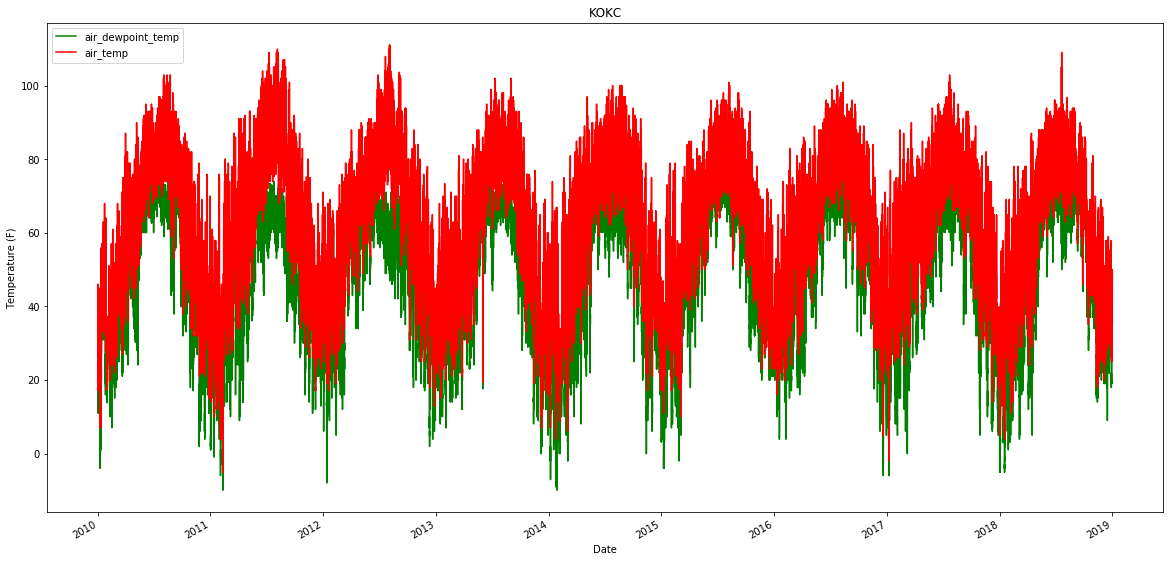

In [5]:
ax = plt.gca()
df.plot(figsize=(20,10), title='KOKC', kind='line', x='obs_date_time', y='air_dewpoint_temp', color='green', ax=ax)
df.plot(kind='line', x='obs_date_time', y='air_temp', color='red', ax=ax)
plt.xlabel('Date')
plt.ylabel('Temperature (F)')

## Plot locations of all stations in ISD

In [7]:
df = pd.read_sql("SELECT DISTINCT obs_latitude, obs_longitude FROM noaaisd.isd where year between 2010 and 2018;", conn)
df

,obs_latitude,obs_longitude
0,71100.0,23983.0
1,68782.0,19702.0
2,65333.0,7317.0
3,58100.0,11333.0
4,62203.0,21170.0
...,...,...
92774,38683.0,69567.0
92775,49740.0,108600.0
92776,59333.0,-108967.0
92777,57800.0,-116883.0


rescale the latitude and longitude

In [8]:
df['obs_latitude'] = df.obs_latitude / 1000.0
df['obs_longitude'] = df.obs_longitude / 1000.0
df

,obs_latitude,obs_longitude
0,71.100,23.983
1,68.782,19.702
2,65.333,7.317
3,58.100,11.333
4,62.203,21.170
...,...,...
92774,38.683,69.567
92775,49.740,108.600
92776,59.333,-108.967
92777,57.800,-116.883


Plot a map, and plot the locations of the stations

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


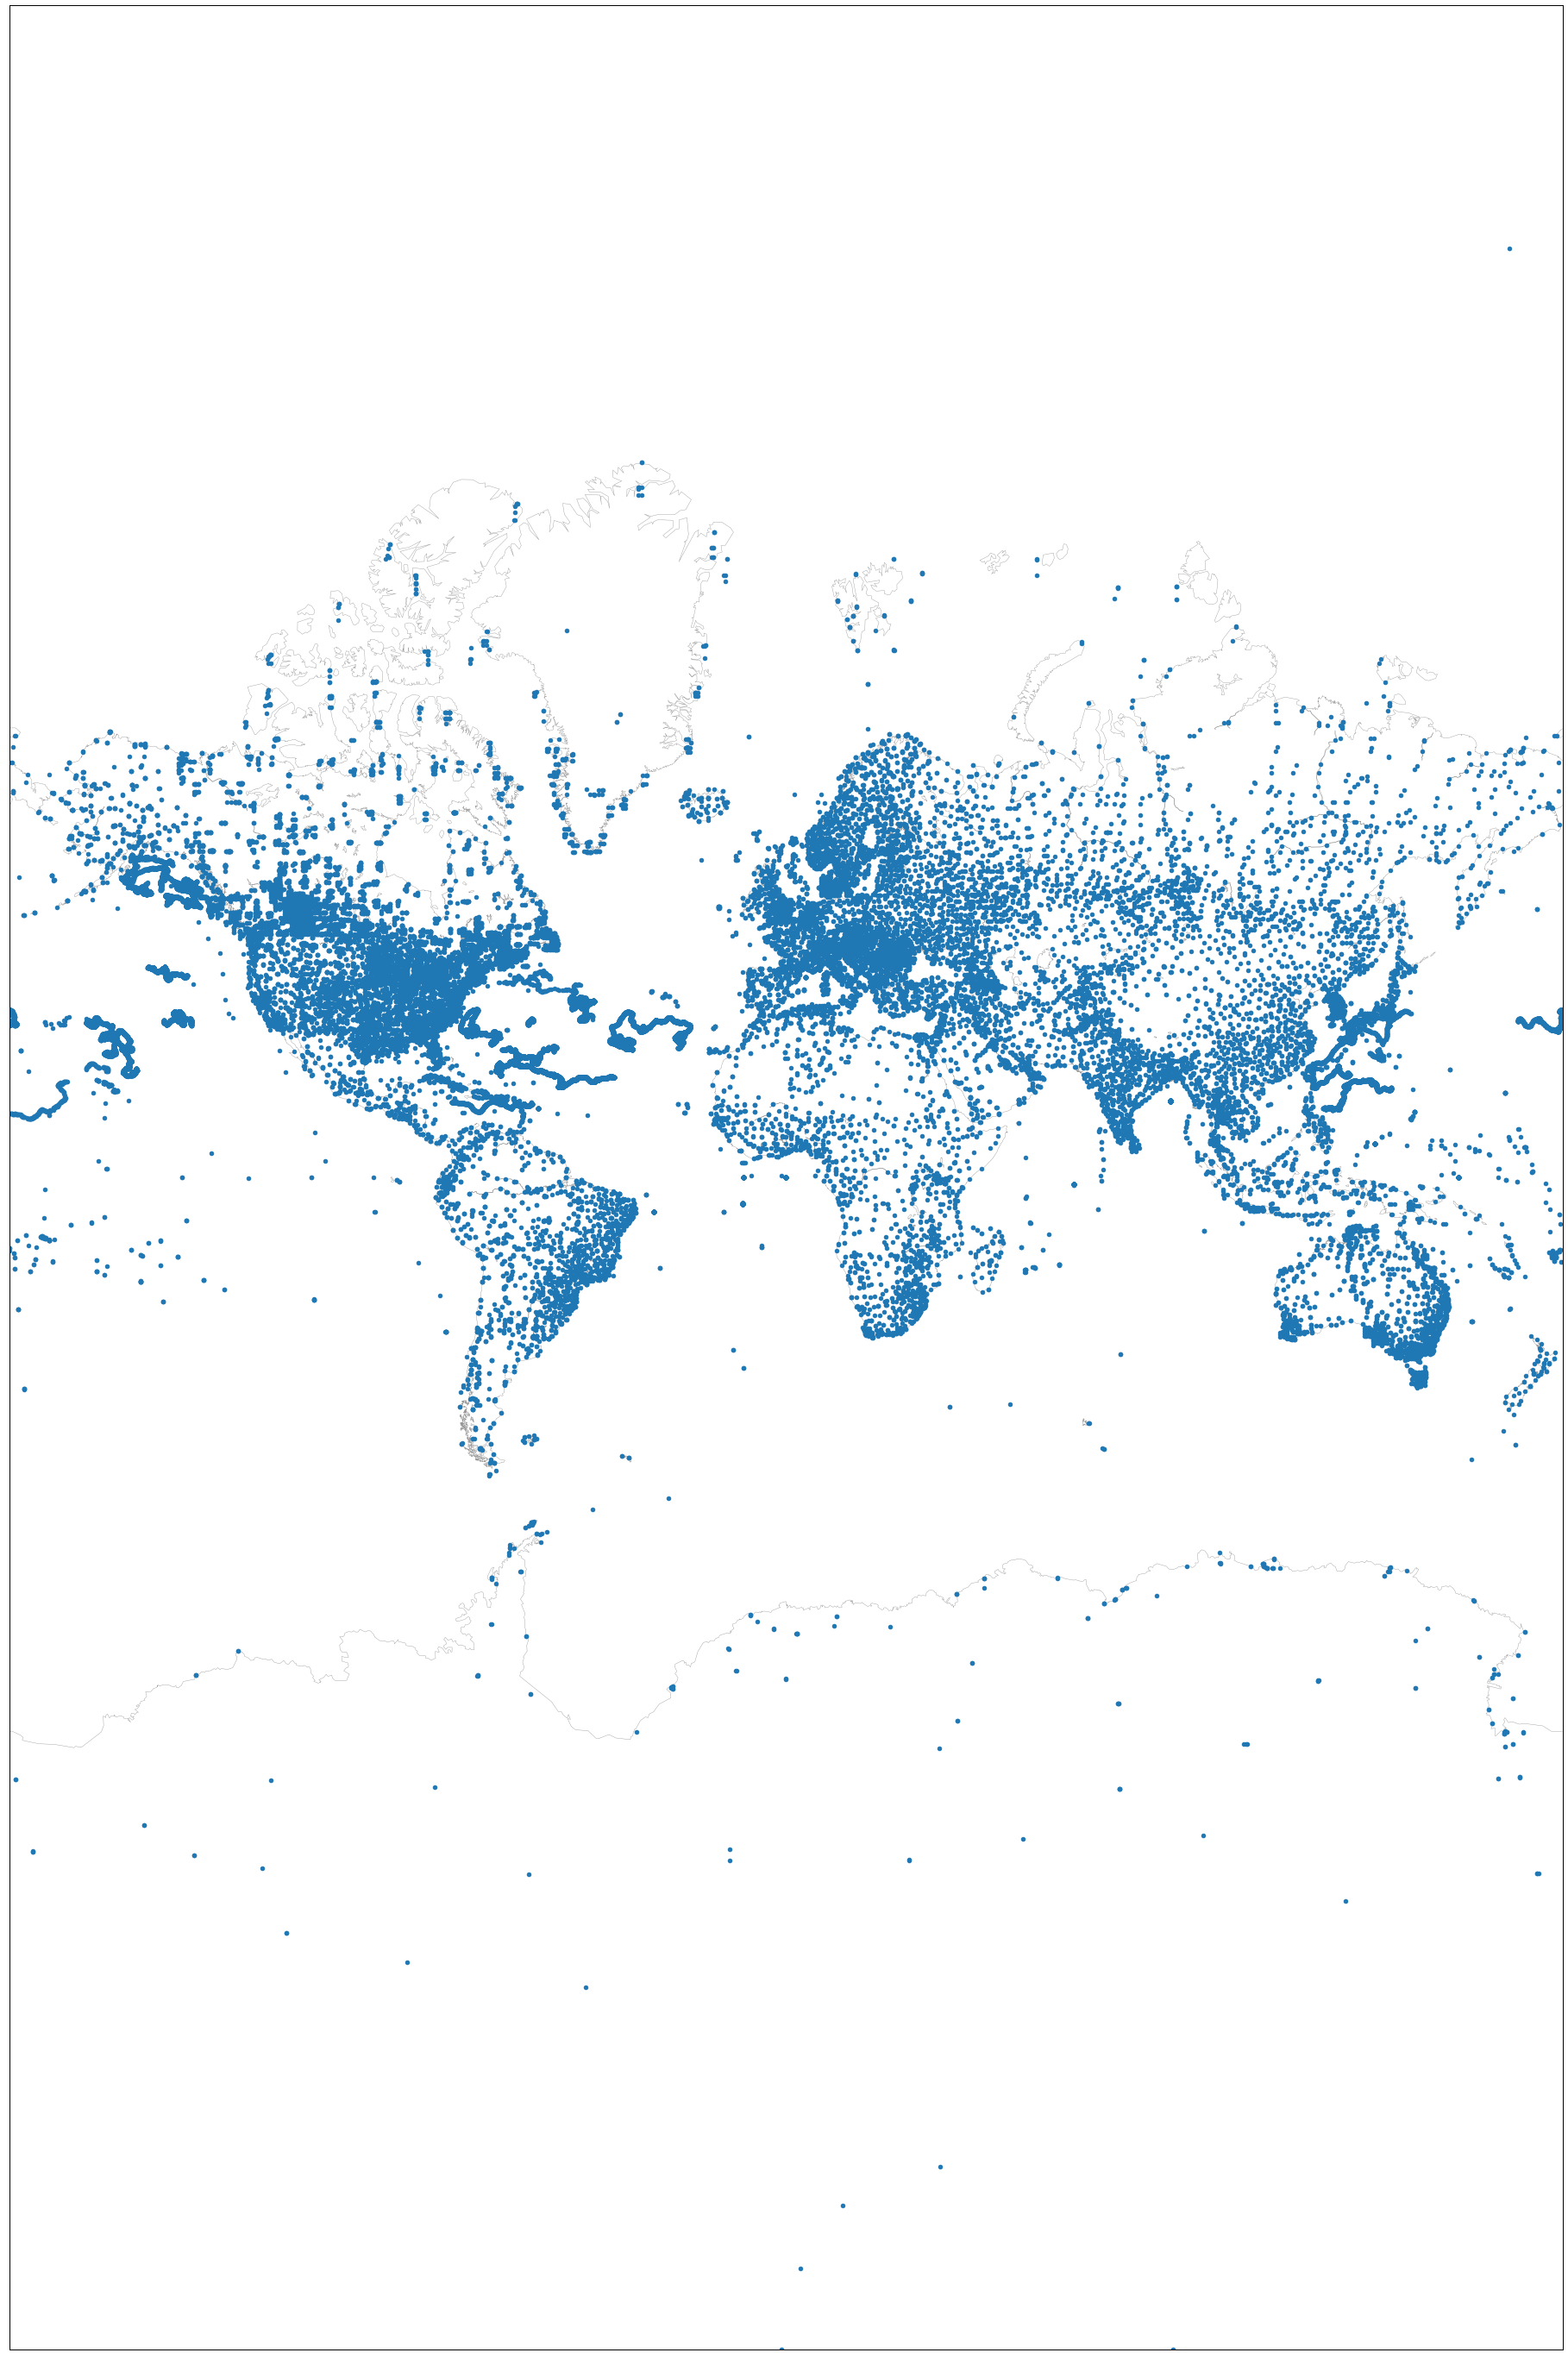

In [9]:
plt.subplots(figsize=(50,50))
m = Basemap(
    projection='merc', 
    llcrnrlat=-89.0, 
    urcrnrlat=89.0, 
    llcrnrlon=-180.0, 
    urcrnrlon=180.0,
    resolution='l'
)

m.drawmapboundary(fill_color='#ffffff')
m.drawcoastlines(color='#999999', linewidth=.4)

m.scatter(df.obs_longitude.tolist(), df.obs_latitude.tolist(), s=20, zorder=2, latlon=True)

plt.show()